## Topic Modeling Altmetric with Gensim's LDAModel Library

Prior to running this code, complete the these notebooks: 
* Topic_Modeling_Altmetric_Data_Loading
* Topic_Modeling_Altmetric_Data_Preprocessing
* Topic_Modeling_Altmetric_Gensim_Bag_of_Words

Topic modeling is a technique for taking some unstructured text and automatically extracting its common themes, it is a great way to get a bird's eye view on a large text collection.

Gensim = “Generate Similar” is a popular open source natural language processing library used for unsupervised topic modeling.

Gensim uses top academic models and modern statistical machine learning to perform various complex tasks such as −

* Building document or word vectors
* Corpora
* Performing topic identification
* Performing document comparison (retrieving semantically similar documents)
* Analysing plain-text documents for semantic structure

However, unlike Scikit-Learn, Gensim doesn’t do any work on behalf of your documents for tokenization or stemming.

The Gensim library uses a popular algorithm for doing topic model, namely Latent Dirichlet Allocation. Latent Dirichlet Allocation (LDA). LDA requires documents to be represented as a bag of words (for the gensim library, some of the API calls will shorten it to "bow"). This representation ignores word ordering in the document but retains information on how many times each word appears.

The main distinguishing feature for LDA is it allows for mixed membership, which means that each document can partially belong to several different topics. Note that the vocabulary probability will sum up to 1 for every topic, but often times, words that have lower weights will be truncated from the output.

Text modified from:

* <https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA>
* <https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py>
* <https://www.tutorialspoint.com/gensim/index.htm>
* https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

In [ ]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika
import inspect
import datetime
import pickle5 as pickle

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import ldaseqmodel


## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [ ]:
## Find the number of documents in each year. 
## This will be important for creating time-slices when using Dynamic Topic Modeling

# time_series = final_df.groupby(['Year']).size()
# print(type(time_series))
# print(time_series)
# print(time_series.index)


In [ ]:
## Convert the time series into a list of "numbers"
## These will be the time-slices used for Dynamic Topic Modeling

# time_slices = time_series.tolist()
# print(time_slices)
# print(len(time_slices))

In [4]:
## Convert the time series index to a list of numbers
## These will be axis values in the visualization for Dynamic Topic Modeling

# time_frame = time_series.index.tolist()
# print(time_frame)
# print(len(time_frame))

### Load data from previous notebooks

In [5]:
## Load data csv as a dataframe
final_df = pd.read_csv("output/loading/final_df.csv", index_col=0) 

## Inspect output as needed
## final_df.head()

In [6]:
## Load data csv as a dataframe
test_df = pd.read_csv("output/processing/nostop_ngrams_partsofspeech_lemmatize.csv", index_col=0) 

## Inspect output as needed
## test_df.head()

In [7]:
## Open text_out_2 pickle file

file_name = "output/processing/texts_out_2.pkl"

open_file = open(file_name, "rb")
texts_out_2 = pickle.load(open_file)
open_file.close()

In [8]:
## Open bow_corpus pickle file

file_name = "output/bow/bow_corpus.pkl"

open_file = open(file_name, "rb")
bow_corpus = pickle.load(open_file)
open_file.close()

In [10]:
## Open dictionary pickle file

file_name = "output/bow/dictionary.pkl"

dictionary = corpora.Dictionary.load(file_name)

# open_file = open(file_name, "rb")
# dictionary = pickle.load(open_file)
# open_file.close()

## Resources
## https://stackoverflow.com/questions/58961983/how-do-you-save-a-model-dictionary-and-corpus-to-disk-in-gensim-and-then-load

In [11]:
## Open id_words_count pickle file

file_name = "output/bow/id_words_count.pkl"

open_file = open(file_name, "rb")
id_words_count = pickle.load(open_file)
open_file.close()

## Run the Gensim Library LDA Model

#### What is required by run_gensim_LDA_model()?

* **bow_corpus:** a list of lists (similar to the data you provided) where the word is represented by a number.
    * Example: [ **[** (0,3), (1,1), (2,1), (3,1) **]** , **[**(2,1), (3,2) **]** ,  **[** (0,1), (1,2), (2,1) **]** ] 
    * In this example, each document is represented by a single list (so there are three documents in the entire corpus) 

* **dictionary:** a gensim.corpora.dictionary.Dictionary which is a list of all the unique words (including bigrams and trigrams, if you created them) in the entire corpus.
    * Example: ['diet','health', 'heart', 'identify'.....]

#### What are the outputs of run_gensim_LDA_model()?

* **topic_model:** a 'gensim.models.ldamodel.LdaModel'
* **topics:** a list of topics represented as (word, probability); list of {str, tuple of (str, float)}
    * Example: [**(**0, [('study', 0.019469742), ('risk', 0.016865147), ('health', 0.013026147)]**)** , **(**1, [('young', 0.008681836), ('year', 0.00835282), ('blood', 0.008228943)]**)**
    * In this example there are two topics identified from the corpus.
 * Probability is the probability of those words appearing in the topic. 
 * Phi value is the probability of the word belonging to that particular topic. 
 * And the sum of phi values for a given word adds up to the number of times that word occurred in that document.

Resources: 
<https://www.machinelearningplus.com/nlp/gensim-tutorial/#12howtointerprettheldatopicmodelsoutput>


In [14]:
## Run the Gensim Library LDA Model
## See link below if you want to save and load a model
## https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA

def run_gensim_LDA_model(corpus, dictionary):
    ##Directory for storing all lda models
    model_dir = 'lda_checkpoint'

    ##If model_dir directionry is not in the folder, then make the directory
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    ##Load the model if we've already trained it before
    ##If there's no previous model, then we will be training the model on the corpus
   
    path = os.path.join(model_dir, 'gensim_tutorial_topic_model.lda')
    if not os.path.isfile(path):
        ## Training LDA can take some time,which is why this function saves the model. Be sure to delete the file if you want to re-run the model without using the previous model.  
        ## Parameters for LdaModel include:
        ## corpus, also known as bag of words, which is a stream of document vectors or sparse matrix of shape (matrix of word/document association)
        ## id2word, also known as dictionary, which is each word in the corpus with a unique integer ID
        ## num-topic, number of topics to be returned, arbitrary at first, but later you will know how many by calcaulating coherence scores 
        ## iterations, Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
        ## per_word_topics, If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word, along with their phi values multiplied by the feature length (i.e. word count)
        ## eval_every,  if set to None to not evaluate the model perplexity
        ## random_state=100, ??
        ## update_every=1, Either a randomState object or a seed to generate one. Useful for reproducibility.
        ## chunksize=100,Number of documents to be used in each training chunk.
        ## passes=10, Number of passes through the corpus during training.
        ## alpha='auto',  Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability.
        ## Resources
        ## https://radimrehurek.com/gensim/models/ldamodel.html
        ## https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#things-to-experiment-with
        
        topic_model_LDA = LdaModel(corpus, id2word = dictionary, num_topics = 4, iterations = 200)
        topic_model_LDA.save(path)
 
    topic_model_LDA = LdaModel.load(path)

    ## Each element of the list is a tuple containing the topic and word / probability list
    ## Each topic has many words, but only 15 are shown here. Increase or decrease this as needed
    topics_LDA = topic_model_LDA.show_topics(num_words = 100, formatted = False)
    
    ## Print the outputs and inspect as needed
    #print(type(topic_model_LDA))
    #print(topic_model_LDA)
    #print(type(topics_LDA))
    #print(topics)LDA
  
    
    return topic_model_LDA, topics_LDA

topic_model_LDA, topics_LDA = run_gensim_LDA_model(bow_corpus, dictionary)

In [15]:
print(type(topic_model_LDA))
print(type(topics_LDA))

<class 'gensim.models.ldamodel.LdaModel'>
<class 'list'>


In [16]:
##Create dataframe for topics
df_topics_LDA = pd.DataFrame(topics_LDA, columns = ['TopicNum', 'Terms'])
#df_topics.head()

## Explode the list tuples with Term/Probability into rows
Term = []
Probability = []
TopicNumber = []

def create_lists(row):
    tuples = row['Terms']
    topic = row['TopicNum']
    for t in tuples:
        Term.append(t[0])
        Probability.append(t[1])
        TopicNumber.append(topic)

df_topics_LDA.apply(create_lists, axis=1)

df_topics_LDA_final = pd.DataFrame({"Term" : Term, "Probability": Probability, "Topic_Number": TopicNumber})[["Topic_Number","Term", "Probability"]]
df_topics_LDA_final.head()
## https://stackoverflow.com/questions/44758596/split-a-list-of-tuples-in-a-column-of-dataframe-to-columns-of-a-dataframe


,Topic_Number,Term,Probability
0,0,marijuana,0.006865
1,0,diabetes,0.006163
2,0,public,0.005648
3,0,link,0.005261
4,0,kidney,0.005040


In [17]:
## Save topics to CSV
with open(r"output/lda_model/LDAModel_topics.csv", 'w', encoding='utf-8') as file:
    df_topics_LDA_final.to_csv(file, index=False, line_terminator='\n')
    file.close()   

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [18]:
## In case of problems use
## https://stackoverflow.com/questions/47998685/pyldavis-validation-error-on-trying-to-visualize-topics
## topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1)[:, None]

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model_LDA, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.043853 -0.009609       1        1  31.476959
0      0.007716  0.000074       2        1  28.435644
3     -0.038396 -0.021663       3        1  20.671625
1     -0.013173  0.031198       4        1  19.415770, topic_info=              Term         Freq        Total Category  logprob  loglift
1344      diabetes  1818.000000  1818.000000  Default  30.0000  30.0000
127       pressure  1792.000000  1792.000000  Default  29.0000  29.0000
2273         sleep   346.000000   346.000000  Default  28.0000  28.0000
1886        kidney   385.000000   385.000000  Default  27.0000  27.0000
3120   gestational   323.000000   323.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
216        percent   163.916565  1007.244263   Topic4  -5.4425  -0.1765
326           lung   138.212357   709.408508   Topic4  -5.6130   0.0034
276           diet   141.270523   820.864624   Topic4  -5.5911  -0.1206
280            eat   126.055542   613.121887   Topic4  -5.7051   0.0572
69    hypertension   122.518974   656.600220   Topic4  -5.7336  -0.0397

[366 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
4674      1  0.158200  absorb_unpredictable
4674      2  0.790999  absorb_unpredictable
2044      1  0.170590                 abuse
2044      2  0.213237                 abuse
2044      3  0.477652                 abuse
...     ...       ...                   ...
741       4  0.713678         working_class
742       1  0.172701                 world
742       2  0.497379                 world
742       3  0.200333                 world
742       4  0.131253                 world

[870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

### Explanation of pyLDA visualization

"There are a lot of moving parts in the visualization. Here's a brief summary:

On the left, there is a plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map)

* The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally similar should be appear close together on the plot, while dissimilar topics should appear far apart.

* The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

* An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

On the right, there is a bar chart showing top terms.

* When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

* When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter $\lambda$, which can be adjusted with a slider above the bar chart.

    * Setting the $\lambda$ parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic. 
    * Setting $\lambda$ close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.
    
    * Setting $\lambda$ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.

* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

### Important Note: 
Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually."

Text from: <https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb>

Resource(s):
* <https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf>

## Test the Model Perplexity and Coherence

In [20]:
## Test Model Perplexity and Coherence

def model_perplexity_coherence_lda(bow_corpus, dictionary, texts_out_2, topic_model_LDA):
    
    ##Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
    ##In my experience, topic coherence score, in particular, has been more helpful.
    ## https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=Topic%20Modeling%20is%20a%20technique,in%20the%20Python's%20Gensim%20package.

    ## Compute Perplexity
    ## The LDA model (lda_model) we have created above can be used to compute the model’s perplexity, 
    ## i.e. how good the model is. The lower the score the better the model will be.
    perplexity_lda = topic_model_LDA.log_perplexity(bow_corpus)
    print('\nPerplexity: ',  perplexity_lda)  # a measure of how good the model is. lower the better.
    
    ## Compute Coherence
    ## The LDA model (lda_model) we have created above can be used to compute the model’s coherence score 
    ## i.e. the average /median of the pairwise word-similarity scores of the words in the topic. 
    coherence_model_lda = CoherenceModel(model=topic_model_LDA, texts=texts_out_2, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    return perplexity_lda, coherence_lda

perplexity_lda, coherence_lda = model_perplexity_coherence_lda(bow_corpus, dictionary, texts_out_2, topic_model_LDA)


Perplexity:  -7.461549028317965

Coherence Score:  0.30348872361405277


### Finding dominant topics in sentences for LDAModel

Finding dominant topics in sentences is one of the most useful practical applications of topic modeling. It determines what topic a given document is about. Here, we will find that topic number which has the highest percentage contribution in that particular document. In order to aggregate the information in a table, we will be creating a function named dominant_topics() 

Text from: 
* <https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

Resources:
* <https://stackoverflow.com/questions/44571617/probabilities-returned-by-gensims-get-document-topics-method-doesnt-add-up-to>

#### What is required by format_topics_sentences_ldal()?

* **texts_out_2:** Tokenized, lemmatized words for each document in your corpus, in the form of a "list of lists". 
    * Example: [['identify', 'nonprofit', 'member', 'health'], ['member', 'health', 'service'], ['identify', 'heart', 'health', 'diet']]

* **bow_corpus:** a list of lists (similar to the data you provided) where the word is represented by a number.
    * Example: [ **[** (0,3), (1,1), (2,1), (3,1) **]** , **[**(2,1), (3,2) **]** ,  **[** (0,1), (1,2), (2,1) **]** ] 
    * In this example, each document is represented by a single list (so there are three documents in the entire corpus) 

* **topic_model:** a 'gensim.models.ldamodel.LdaModel'


#### What is the output of format_topics_sentences_ldal()?
* **df_dominant_topic:** A dataframe with the dominant topic for each document in the corpus, along with the percent to which the document contributes tokens to that topic, the keywords of the dominant topic, and the "texts_out_2" for the document. 

In [60]:
def format_topics_sentences_lda(ldamodel=topic_model_LDA, corpus=bow_corpus, texts=texts_out_2):
    
    ## Init dataframe for output
    sent_topics_lda_df = pd.DataFrame()
    
    ## Next, we will get the main topics in every document −
           
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        print(i)
        print(row)
        #row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        ## https://stackoverflow.com/questions/59465247/type-error-while-finding-dominant-topics-in-each-sentence-in-gensim
        
        
        ## Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_lda_df = sent_topics_lda_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    
    sent_topics_lda_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents_lda = pd.Series(texts)
    sent_topics_lda_df = pd.concat([sent_topics_lda_df, contents_lda], axis=1)
    
    return(sent_topics_lda_df)

## Call function as needed
df_topic_sents_keywords_lda = format_topics_sentences_lda(ldamodel=topic_model_LDA, corpus=bow_corpus, texts=texts_out_2)

# Format dataframe as needed
df_dominant_topic_lda = df_topic_sents_keywords_lda.reset_index()
df_dominant_topic_lda.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

## Merge with final_df to get document information
dominant_topic_final_lda = df_dominant_topic_lda.merge(final_df, left_on = 'Document_No', right_index=True).drop(columns= ['title',
                                                                                                                            'metadata', 
                                                                                                                            'content', 
                                                                                                                            'status',
                                                                                                                            'file_name',
                                                                                                                            #'preprocess',
                                                                                                                            #'tokens',
                                                                                                                            #'no_stop',
                                                                                                                            #'bigrams',
                                                                                                                            #'trigrams',
                                                                                                                            #'parts_of_speech',
                                                                                                                            #'lemmatize'
                                                                                                                             ])


# Show
dominant_topic_final_lda.head(10)

0
[(1, 0.9113262), (3, 0.08648945)]
1
[(0, 0.9961766)]
2
[(0, 0.4599456), (1, 0.29295734), (2, 0.24627687)]
3
[(0, 0.9252559), (3, 0.071072645)]
4
[(0, 0.9982979)]
5
[(1, 0.99715453)]
6
[(1, 0.9971445)]
7
[(1, 0.99812335)]
8
[(1, 0.99771494)]
9
[(1, 0.99242824)]
10
[(1, 0.99634457)]
11
[(1, 0.7806031), (2, 0.2165685)]
12
[(3, 0.993529)]
13
[(1, 0.99453413)]
14
[(2, 0.9981975)]
15
[(2, 0.9978622)]
16
[(1, 0.6529838), (2, 0.34438807)]
17
[(1, 0.7730011), (2, 0.22464032)]
18
[(1, 0.99663496)]
19
[(2, 0.6891513), (1, 0.30962256)]
20
[(1, 0.9969335)]
21
[(1, 0.9937052)]
22
[(1, 0.99435234)]
23
[(1, 0.99607235)]
24
[(2, 0.5394051), (1, 0.45691258)]
25
[(0, 0.61907953), (1, 0.3799547)]
26
[(3, 0.8442724), (1, 0.15416881)]
27
[(1, 0.99487025)]
28
[(0, 0.9975957)]
29
[(1, 0.99611837)]
30
[(1, 0.6973529), (2, 0.29971296)]
31
[(0, 0.4936658), (1, 0.3575359), (2, 0.14830466)]
32
[(2, 0.995741)]
33
[(0, 0.5806675), (2, 0.24065341), (3, 0.17723091)]
34
[(2, 0.9943324)]
35
[(2, 0.85543925), (1, 0.142

282
[(0, 0.9971211)]
283
[(3, 0.98342913)]
284
[(0, 0.998664)]
285
[(3, 0.9838707)]
286
[(0, 0.9950044)]
287
[(3, 0.98725754)]
288
[(3, 0.98169976)]
289
[(2, 0.46676025), (3, 0.45525154), (0, 0.0772217)]
290
[(0, 0.9936382)]
291
[(0, 0.52789015), (3, 0.47033632)]
292
[(0, 0.99340117)]
293
[(0, 0.9952927)]
294
[(3, 0.5979093), (0, 0.39986107)]
295
[(0, 0.63243115), (2, 0.32475987), (3, 0.041875634)]
296
[(3, 0.552427), (0, 0.44533318)]
297
[(2, 0.997697)]
298
[(0, 0.52978724), (2, 0.27739578), (1, 0.19199967)]
299
[(0, 0.9628626), (2, 0.035408523)]
300
[(0, 0.9958052)]
301
[(0, 0.9952176)]
302
[(0, 0.99747515)]
303
[(1, 0.8850728), (0, 0.11186078)]
304
[(3, 0.7012309), (1, 0.2868027)]
305
[(0, 0.9951642)]
306
[(1, 0.9978787)]
307
[(1, 0.99570155)]
308
[(1, 0.9944832)]
309
[(1, 0.61137354), (3, 0.22483394), (0, 0.16232549)]
310
[(1, 0.9983705)]
311
[(0, 0.995756)]
312
[(3, 0.5582041), (2, 0.43995583)]
313
[(1, 0.99608076)]
314
[(1, 0.8984331), (0, 0.09856513)]
315
[(0, 0.99574184)]
316
[

580
[(1, 0.6395742), (0, 0.3575105)]
581
[(2, 0.58889544), (1, 0.40917215)]
582
[(1, 0.9974005)]
583
[(1, 0.99743587)]
584
[(1, 0.99730563)]
585
[(2, 0.7618458), (0, 0.23544395)]
586
[(2, 0.99789405)]
587
[(3, 0.7071593), (1, 0.29197982)]
588
[(3, 0.99563193)]
589
[(3, 0.984812), (0, 0.013596567)]
590
[(3, 0.7495049), (2, 0.24788506)]
591
[(2, 0.99754685)]
592
[(2, 0.9966143)]
593
[(3, 0.51583326), (0, 0.48118842)]
594
[(0, 0.74341786), (1, 0.25395387)]
595
[(2, 0.6231089), (1, 0.3750086)]
596
[(0, 0.9970236)]
597
[(2, 0.9960142)]
598
[(1, 0.9957222)]
599
[(3, 0.86778873), (0, 0.12978868)]
600
[(3, 0.7617121), (0, 0.13779764), (2, 0.09935357)]
601
[(0, 0.77792394), (2, 0.21644057)]
602
[(2, 0.99230826)]
603
[(0, 0.98650575)]
604
[(3, 0.85793924), (1, 0.13263811)]
605
[(0, 0.47285444), (1, 0.3215381), (2, 0.20464839)]
606
[(0, 0.7233872), (3, 0.27431065)]
607
[(0, 0.46641797), (3, 0.42659825), (2, 0.10588347)]
608
[(2, 0.990878)]
609
[(2, 0.9963675)]
610
[(2, 0.99636877)]
611
[(2, 0.996

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Database,Document_Type,Reference_Detail,CORE,Authors,Title,Year,Publication_Date,Source_title,Page_start,File_Name,Metadata_Title
0,0,1.0,0.9113,"diabetes, pressure, develop, exercise, man, sl...","[uci, medical, center, award, national, heart,...",Nexis Uni,News Newswire,CO,NONCORE,NaN,UCI MEDICAL CENTER AWARDED $1.3 MILLION FOR NA...,1990,"December 4, 1990, Tuesday",PR Newswire,536 words,CO.105UCI MEDICAL CENTER AWARDED $1.3 MILLION ...,UCI MEDICAL CENTER AWARDED $1.3 MILLION FOR NA...
1,1,0.0,0.9962,"marijuana, diabetes, public, link, kidney, obe...","[kaiser_permanente, study, obese, hostile, dep...",Nexis Uni,News Newswire,CO,NONCORE,NaN,"KAISER PERMANENTE STUDY: IF YOU'RE OBESE, HOST...",1994,"March 18, 1994, Friday",PR Newswire,380 words,CO.105KAISER PERMANENTE STUDY_ IF YOU'RE OBESE...,"KAISER PERMANENTE STUDY: IF YOU'RE OBESE, HOST..."
2,2,0.0,0.4599,"marijuana, diabetes, public, link, kidney, obe...","[young, american, adults, fat, fitter, year, s...",Nexis Uni,News Newswire,CO,NONCORE,NaN,"YOUNG AMERICAN ADULTS BECOMING FATTER, NOT FIT...",1995,"March 10, 1995, Friday",PR Newswire,749 words,"CO.105YOUNG AMERICAN ADULTS BECOMING FATTER, N...","YOUNG AMERICAN ADULTS BECOMING FATTER, NOT FIT..."
3,3,0.0,0.9253,"marijuana, diabetes, public, link, kidney, obe...","[new, estimate, prevalence, hypertrophic_cardi...",Nexis Uni,News Newswire,CO,NONCORE,NaN,New Estimates On The Prevalence Of Hypertrophi...,1995,"August 30, 1995 Wednesday",Reuters Health Medical News,385 words,CO.105New Estimates On The Prevalence Of Hyper...,New Estimates On The Prevalence Of Hypertrophi...
4,4,0.0,0.9983,"marijuana, diabetes, public, link, kidney, obe...","[kaiser_permanente_corrects_misleade, chronicl...",Nexis Uni,News Newswire,CO,NONCORE,NaN,KAISER PERMANENTE CORRECTS MISLEADING S.F. CHR...,1995,"November 7, 1995, Tuesday",PR Newswire,1338 words,CO.105KAISER PERMANENTE CORRECTS MISLEADING S....,KAISER PERMANENTE CORRECTS MISLEADING S.F. CHR...
5,5,1.0,0.9972,"diabetes, pressure, develop, exercise, man, sl...","[symptoms, societal, ills, symptoms, societal,...",Nexis Uni,News Newspaper,CO,NONCORE,R. William,Symptoms of societal ills?,1996,"October 25, 1996, Friday",The Tampa Tribune (Florida),746 words,Commentary.104Symptoms of societal ills_,Symptoms of societal ills?
6,6,1.0,0.9971,"diabetes, pressure, develop, exercise, man, sl...","[hypertension, race, hypertension, race, washi...",Nexis Uni,News Newspaper,CO,NONCORE,R. William,Hypertension and Race,1996,"October 25, 1996, Friday, Final Edition",The Washington Post,732 words,Commentary.104Hypertension and Race,Hypertension and Race
7,7,1.0,0.9981,"diabetes, pressure, develop, exercise, man, sl...","[study, discrimination, may, cause, hypertensi...",Nexis Uni,News Newspaper,CO,NONCORE,W. P. S. W. David Brown,Study: Discrimination May Cause Hypertension i...,1996,"October 24, 1996, Thursday, Final Edition",The Washington Post,1160 words,CO.105Study_ Discrimination May Cause Hyperten...,Study: Discrimination May Cause Hypertension i...
8,8,1.0,0.9977,"diabetes, pressure, develop, exercise, man, sl...","[study, links, racial, bias, blood, pressure, ...",Nexis Uni,News Newspaper,CO,NONCORE,T. W. P. David Brown,"STUDY LINKS RACIAL BIAS, BLOOD PRESSURE",1996,"October 24, 1996, Thursday",Pittsburgh Post-Gazette (Pennsylvania),872 words,"CO.105STUDY LINKS RACIAL BIAS, BLOOD PRESSURE","STUDY LINKS RACIAL BIAS, BLOOD PRESSURE"
9,9,1.0,0.9924,"diabetes, pressure, develop, exercise, man, sl...","[positive, correlation, weight, fasting_insuli...",Nexis Uni,News Newswire,CO,NONCORE,NaN,Positive Correlation Between Body Weight And F...,1996,"August 1, 1996 Thursday",Reuters Health Medical News,247 words,CO.105Positive Correlation Between Body Weight...,Positive Correlation Between Body Weight And F...


In [25]:
## Save dataframe to csv
with open(r"output/lda_model/LDAModel_dominant_topics.csv", 'w', encoding='utf-8') as file:
    dominant_topic_final_lda.to_csv(file, index=False, line_terminator='\n')
    file.close()

### Finding Most Representative Document for LDAModel
"In order to understand more about the topic, we can also find the documents a given topic has contributed to the most. We can infer that topic by reading that particular document(s)."

Text from: 
* <https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [27]:
## Find top 5 most representative documents for each topics
sent_topics_sorted_lda_df = pd.DataFrame()

sent_topics_out_lda_df_grpd = df_dominant_topic_lda.groupby('Dominant_Topic')

for i, grp in sent_topics_out_lda_df_grpd:
    sent_topics_sorted_lda_df = pd.concat([sent_topics_sorted_lda_df, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

## Reset Index    
sent_topics_sorted_lda_df.reset_index(drop=True, inplace=True)

## Merge with final_df to get document information
most_representative_topic_lda = sent_topics_sorted_lda_df.merge(final_df, left_on = 'Document_No', right_index=True).drop(columns= ['title',
                                                                                                                            'metadata', 
                                                                                                                            'content', 
                                                                                                                            'status',
                                                                                                                            'file_name'
                                                                                                                            #'preprocess',
                                                                                                                            #'tokens',
                                                                                                                            #'no_stop',
                                                                                                                            #'bigrams',
                                                                                                                            #'trigrams',
                                                                                                                            #'parts_of_speech',
                                                                                                                            #'lemmatize'
                                                                                                                             ])



## Show
most_representative_topic_lda.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Database,Document_Type,Reference_Detail,CORE,Authors,Title,Year,Publication_Date,Source_title,Page_start,File_Name,Metadata_Title
0,557,0.0,0.9990,"marijuana, diabetes, public, link, kidney, obe...","[marijuana_legalization_raise, need, research,...",Nexis Uni,News Blog,CO,NONCORE,NaN,Marijuana legalization raises the need for mor...,2017,"June 21, 2017 Wednesday",Medical Xpress,2239 words,CO.35Marijuana legalization raises the need fo...,Marijuana legalization raises the need for mor...
1,554,0.0,0.9990,"marijuana, diabetes, public, link, kidney, obe...","[dazed_confuse, marijuana_legalization_raise, ...",Nexis Uni,News Newswire,CO,NONCORE,S. Targeted News,Dazed and Confused: Marijuana Legalization Rai...,2017,"June 20, 2017 Tuesday",Targeted News Service,2141 words,CO.35Dazed and Confused_ Marijuana Legalizatio...,Dazed and Confused: Marijuana Legalization Rai...
2,284,0.0,0.9987,"marijuana, diabetes, public, link, kidney, obe...","[broad, assessment, may, improve, identificati...",Nexis Uni,News Newswire,CO,NONCORE,S. States News,BROADER ASSESSMENT MAY IMPROVE IDENTIFICATION ...,2013,"November 12, 2013 Tuesday",States News Service,1555 words,CO.63BROADER ASSESSMENT MAY IMPROVE IDENTIFICA...,BROADER ASSESSMENT MAY IMPROVE IDENTIFICATION ...
3,271,0.0,0.9985,"marijuana, diabetes, public, link, kidney, obe...","[acc_aha_release, new_guideline_assesse, cardi...",Nexis Uni,News Blog,CO,NONCORE,NaN,ACC/AHA Release New Guideline for Assessing Ca...,2013,"November 12, 2013 Tuesday",NewMediaWire,1719 words,CO.63ACC_AHA Release New Guideline for Assessi...,ACC/AHA Release New Guideline for Assessing Ca...
4,272,0.0,0.9985,"marijuana, diabetes, public, link, kidney, obe...","[acc_aha_release, new_guideline_assesse, cardi...",Nexis Uni,News Newswire,CO,NONCORE,S. Targeted News,ACC/AHA Release New Guideline for Assessing Ca...,2013,"November 12, 2013 Tuesday",Targeted News Service,1472 words,CO.63ACC_AHA Release New Guideline for Assessi...,ACC/AHA Release New Guideline for Assessing Ca...
5,244,1.0,0.9991,"diabetes, pressure, develop, exercise, man, sl...","[viropharma_announces_first, eu_market_launch_...",Nexis Uni,News Newswire,CO,NONCORE,NaN,ViroPharma Announces The First EU Market To La...,2012,"September 20, 2012 Thursday",PR Newswire Europe,2484 words,Bibliography.70ViroPharma Announces The First ...,ViroPharma Announces The First EU Market To La...
6,37,1.0,0.9989,"diabetes, pressure, develop, exercise, man, sl...","[periscope, periscope, newsweek, november, atl...",Nexis Uni,News Magazine,CO,NONCORE,H. T. George Wehrfritz; R. W. B. J. Lee; M. R....,Periscope,2003,10-Nov-03,Newsweek,2209 words,CO.100Periscope,Periscope
7,310,1.0,0.9984,"diabetes, pressure, develop, exercise, man, sl...","[federal_contracts_awarded_companies, californ...",Nexis Uni,News Newswire,CO,NONCORE,T. N. S. by Donabel Harms,Federal Contracts Awarded to Companies in Cali...,2013,"August 16, 2013 Friday",Targeted News Service,1731 words,CO.66Federal Contracts Awarded to Companies in...,Federal Contracts Awarded to Companies in Cali...
8,60,1.0,0.9981,"diabetes, pressure, develop, exercise, man, sl...","[risk, stroke, coronary, heart, disease, chd, ...",Nexis Uni,News Newswire,CO,NONCORE,NaN,The Risk of Both Stroke and Coronary Heart Dis...,2005,"February 8, 2005 Tuesday",PR Newswire US,1362 words,Bibliography.98The Risk of Both Stroke and Cor...,The Risk of Both Stroke and Coronary Heart Dis...
9,7,1.0,0.9981,"diabetes, pressure, develop, exercise, man, sl...","[study, discrimination, may, cause, hypertensi...",Nexis Uni,News Newspaper,CO,NONCORE,W. P. S. W. David Brown,Study: Discrimination May Cause Hypertension i...,1996,"October 24, 1996, Thursday, Final Edition",The Washington Post,1160 words,CO.105Study_ Discrimination May Cause Hyperten...,Study: Discrimination May Cause Hypertension i...


In [28]:
## Save dataframe to csv
with open(r"output/LDAModel_most_representative_document.csv", 'w', encoding='utf-8') as file:
    most_representative_topic_lda.to_csv(file, index=False, line_terminator='\n')
    file.close()

### Topic distribution across documents for LDAModel

"Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information."

Text from: 
* <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [29]:
## Number of Documents for Each Topic
topic_counts_lda = df_topic_sents_keywords_lda['Dominant_Topic'].value_counts()
#print(topic_counts_lda)

## Percentage of Documents for Each Topic
topic_contribution_lda = round(topic_counts_lda/topic_counts_lda.sum(), 4)
#print(topic_contribution_lda)

## Topic Number and Keywords
#topic_num_keywords_lda = df_topic_sents_keywords_lda[['Dominant_Topic', 'Topic_Keywords']]
#print(topic_num_keywords_lda)

## Concatenate Column wise
df_dominant_topics_lda = pd.concat([topic_counts_lda, topic_contribution_lda], axis=1)
#print(df_dominant_topics_lda)

## Change Column names
df_dominant_topics_lda.columns = ['Num_Documents', 'Perc_Documents']

## Show
df_dominant_topics_lda

,Num_Documents,Perc_Documents
2.0,242,0.3297
0.0,203,0.2766
3.0,161,0.2193
1.0,128,0.1744


In [30]:
## Save dataframe to csv
with open(r"output/lda_model/LDAModel_topic_distribution.csv", 'w', encoding='utf-8') as file:
    df_dominant_topic_lda.to_csv(file, index=False, line_terminator='\n')
    file.close()

### Plot the word counts and the weights of each keyword

"When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process."

Text from: 
* <https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#10.-Word-Counts-of-Topic-Keywords>

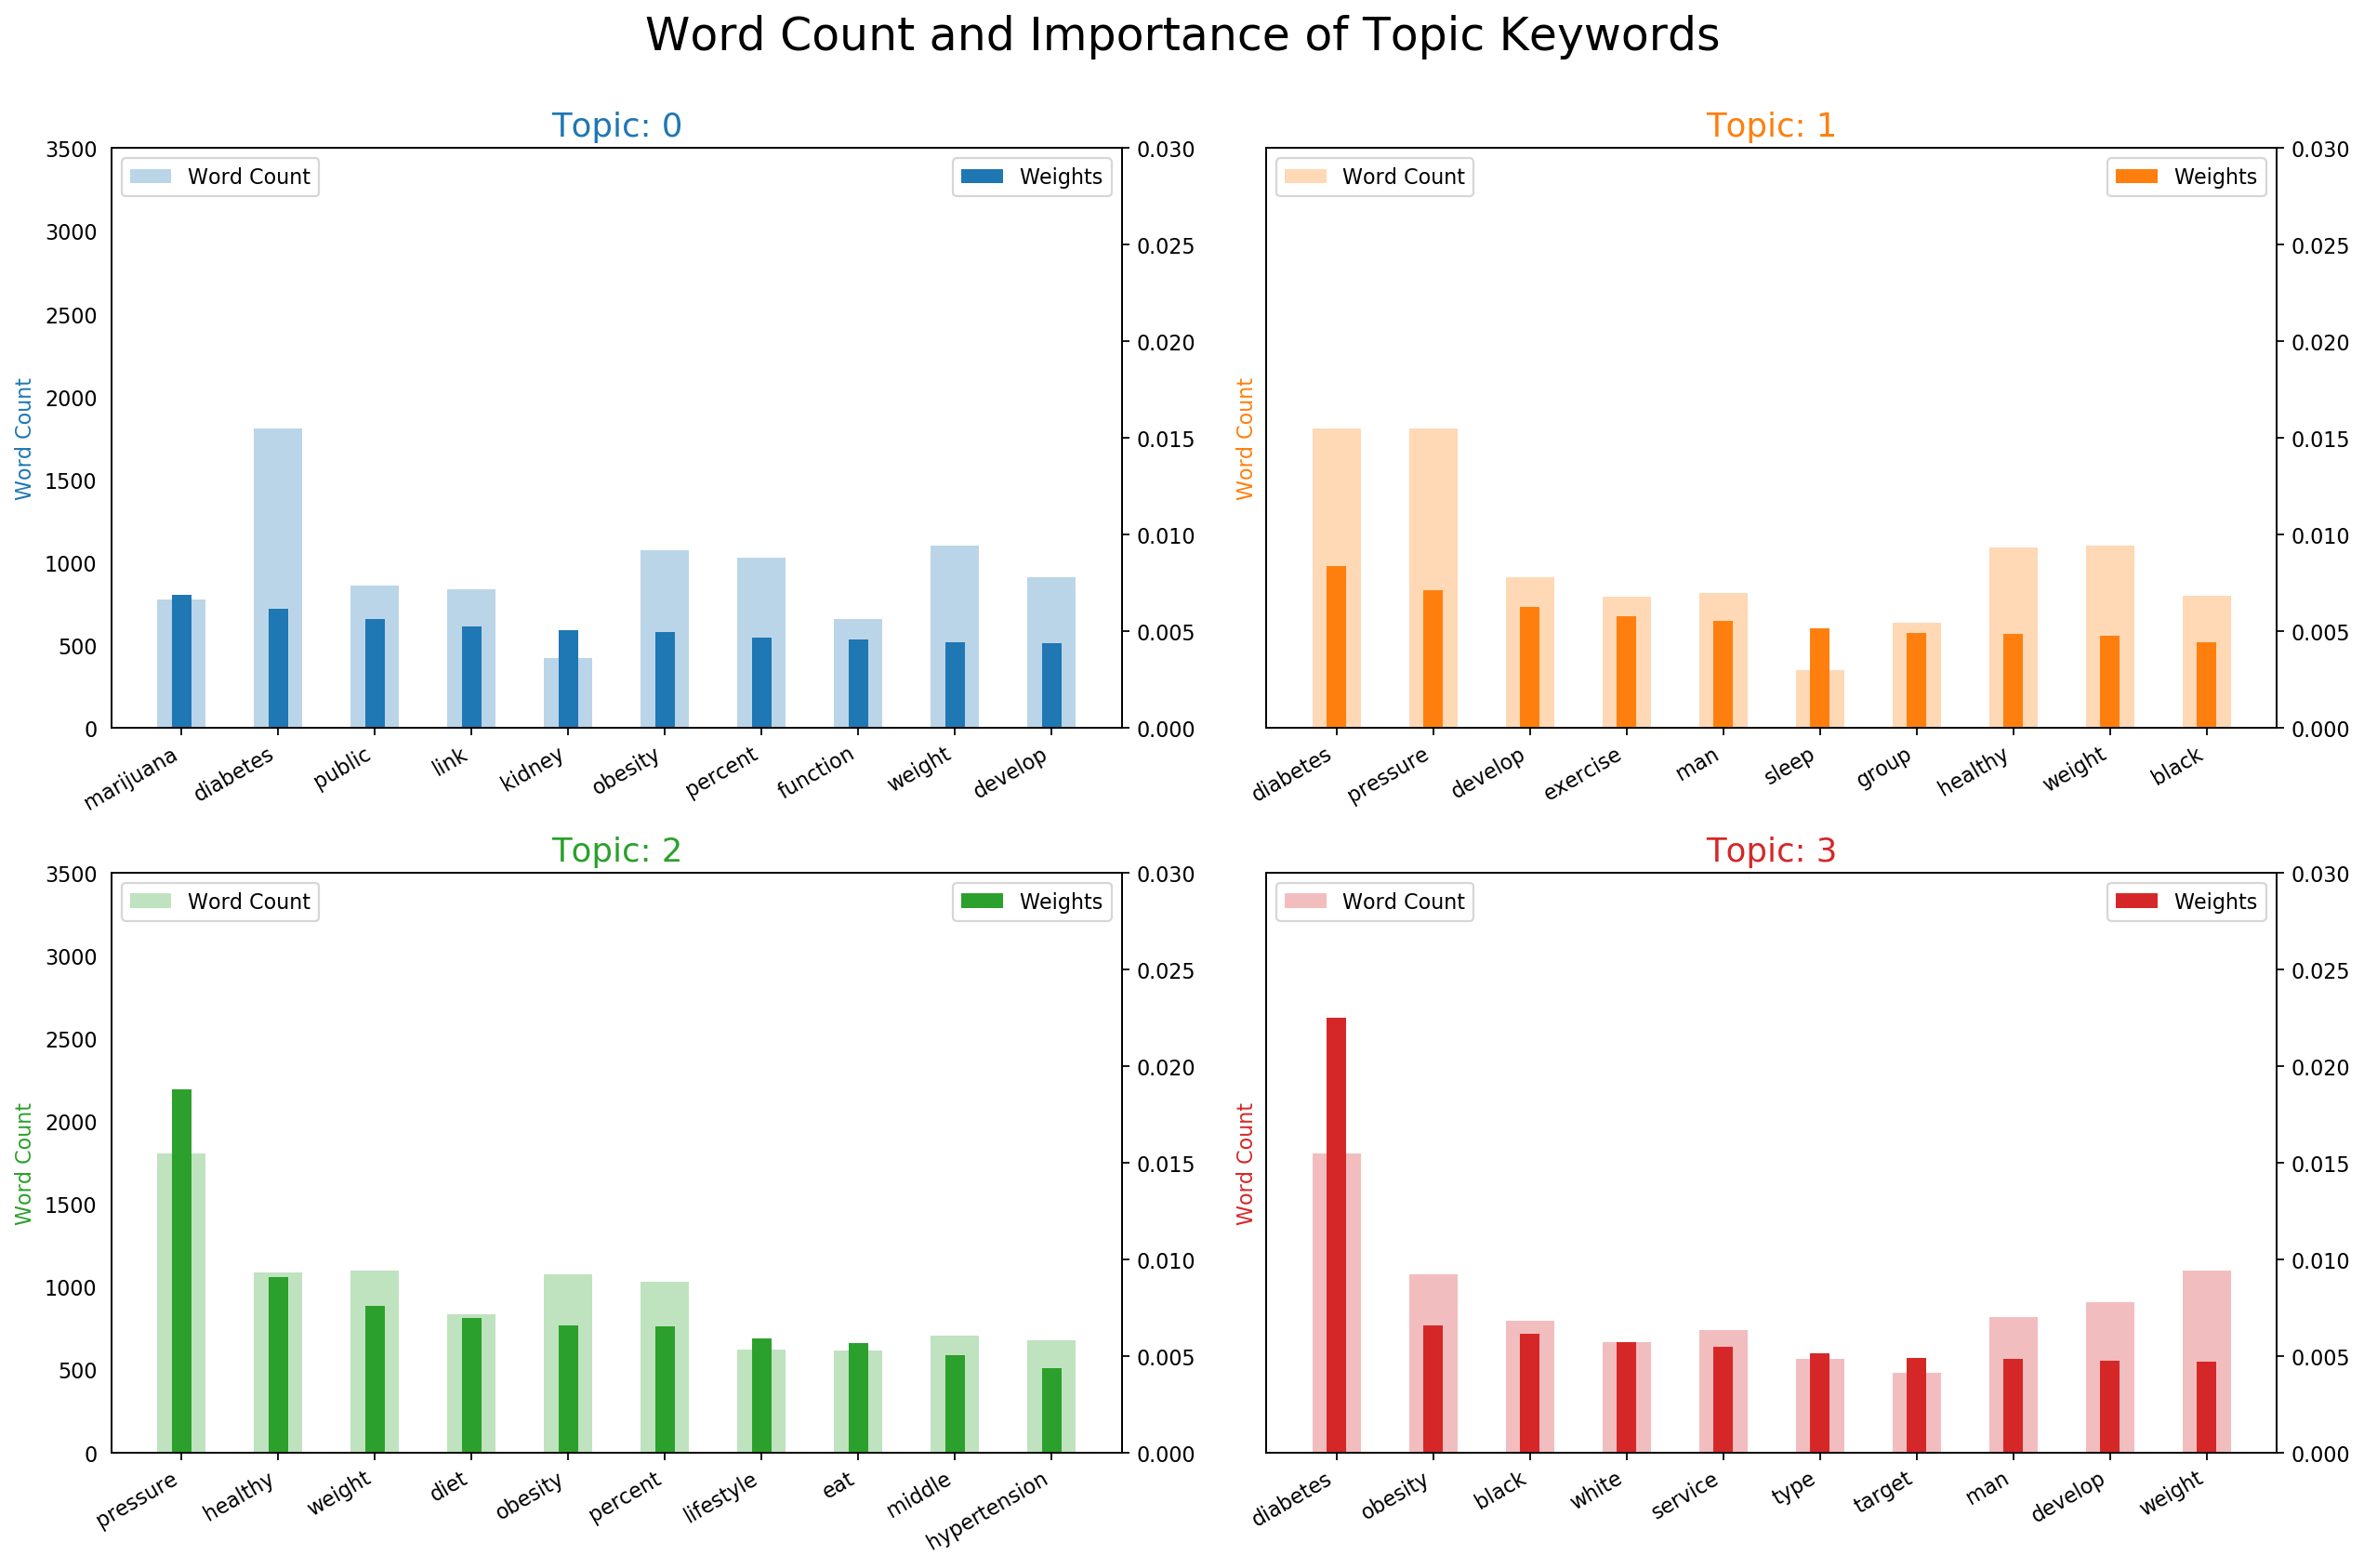

In [32]:
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors

visualize_topics_LDA = topic_model_LDA.show_topics(formatted=False)
data_flat_LDA = [w for w_list in texts_out_2 for w in w_list]
counter = Counter(data_flat_LDA)

out = []
for i, topic in visualize_topics_LDA:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

visualize_topics_LDA_df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=visualize_topics_LDA_df.loc[visualize_topics_LDA_df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=visualize_topics_LDA_df.loc[visualize_topics_LDA_df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(visualize_topics_LDA_df.loc[visualize_topics_LDA_df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   

# save the figure
plt.savefig('output/lda_model/LDAModel_wordcount_weight.png', dpi=300, bbox_inches='tight')

plt.show()

### Find optimal number of topics using the LDAModel Coherence Score

"My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large."

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>


In [33]:
## This step will likely take some time to run. 
## Find the optimal number of topics by running the LDAModel on multiple numbers of topics, here we are using topics 1 - 20
## The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

def coherence_values_computation_lda(dictionary, corpus, texts, limit, start, step):
    perplexity_values_lda_list = []
    coherence_values_lda_list = []
    model_list_lda = []
    
    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,iterations = 200, per_word_topics=True )
        model_list_lda.append(model)
                        
        ## Compute Perplexity Value
        ## The LDA models (model) we created above can be used to compute the model’s perplexity, 
        ## i.e. how good the model is. The lower the score the better the model will be.
        perplexity = model.log_perplexity(corpus)
        perplexity_values_lda_list.append(perplexity)
        
        ## Compute Coherence Value
        ## The LDA model (model) we created above can be used to compute the model’s coherence score 
        ## i.e. the average /median of the pairwise word-similarity scores of the words in the topic. 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda_list.append(coherencemodel.get_coherence())
    
    return model_list_lda, coherence_values_lda_list, perplexity_values_lda_list

model_list_lda, coherence_values_lda_list, perplexity_values_lda_list = coherence_values_computation_lda (dictionary=dictionary, 
                                                                                                             corpus=bow_corpus, 
                                                                                                             texts=texts_out_2, 
                                                                                                             start=1, 
                                                                                                             limit=20, 
                                                                                                             step=1)

## Inspect output as needed
print(coherence_values_lda_list)
print(model_list_lda)
print(perplexity_values_lda_list)



[0.2828624010414688, 0.2947629705033088, 0.3353035466379783, 0.28955450178805786, 0.28068687156067584, 0.2807501492712858, 0.31407945903595486, 0.29504770258754687, 0.2917937768004835, 0.2965951612561014, 0.3170841413877461, 0.3029253119666408, 0.30609444720851414, 0.31786903946390066, 0.299673095714244, 0.28162251114015846, 0.31219856506796395, 0.29842915767746825, 0.3253251364635914]
[<gensim.models.ldamodel.LdaModel object at 0x00000188B2B674E0>, <gensim.models.ldamodel.LdaModel object at 0x00000188B2EAA2B0>, <gensim.models.ldamodel.LdaModel object at 0x00000188B31FE4A8>, <gensim.models.ldamodel.LdaModel object at 0x00000188B29E7F60>, <gensim.models.ldamodel.LdaModel object at 0x00000188B29E7DA0>, <gensim.models.ldamodel.LdaModel object at 0x00000188B2EAA160>, <gensim.models.ldamodel.LdaModel object at 0x00000188B3241828>, <gensim.models.ldamodel.LdaModel object at 0x00000188B324A0B8>, <gensim.models.ldamodel.LdaModel object at 0x00000188B32CB7B8>, <gensim.models.ldamodel.LdaModel o

range(1, 20)
[0.2828624010414688, 0.2947629705033088, 0.3353035466379783, 0.28955450178805786, 0.28068687156067584, 0.2807501492712858, 0.31407945903595486, 0.29504770258754687, 0.2917937768004835, 0.2965951612561014, 0.3170841413877461, 0.3029253119666408, 0.30609444720851414, 0.31786903946390066, 0.299673095714244, 0.28162251114015846, 0.31219856506796395, 0.29842915767746825, 0.3253251364635914]


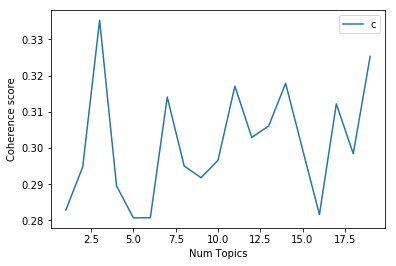

In [34]:
## Visualize the coherence scores for each LDAModel for topics 1 - 20

limit=20 
start=1 
step=1
x = range(start, limit, step)
print(x)
print(coherence_values_lda_list)
plt.plot(x, coherence_values_lda_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save the figure
plt.savefig('output/lda_model/LDAModel_coherence_scores.png', dpi=300, bbox_inches='tight')

plt.show()

In [35]:
## Print and save the Coherence Scores with the Perplexity Value

## Using zip() to map values 
coherence_list_lda_final = list(zip(x, coherence_values_lda_list, perplexity_values_lda_list ))
## print(type(coherence_list_lda_final))

## Create a pandas dataframe from list
LDA_coherence_df = pd.DataFrame(coherence_list_lda_final, columns = ['Number_of_Topics', 'Coherence_Value', 'Perplexity_Value']) 

## Print the coherence scores
for m, cv in zip(x, coherence_values_lda_list):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
## Resources
## https://www.geeksforgeeks.org/zip-in-python/
## https://www.geeksforgeeks.org/create-pandas-dataframe-from-lists-using-zip/

Num Topics = 1  has Coherence Value of 0.2829
Num Topics = 2  has Coherence Value of 0.2948
Num Topics = 3  has Coherence Value of 0.3353
Num Topics = 4  has Coherence Value of 0.2896
Num Topics = 5  has Coherence Value of 0.2807
Num Topics = 6  has Coherence Value of 0.2808
Num Topics = 7  has Coherence Value of 0.3141
Num Topics = 8  has Coherence Value of 0.295
Num Topics = 9  has Coherence Value of 0.2918
Num Topics = 10  has Coherence Value of 0.2966
Num Topics = 11  has Coherence Value of 0.3171
Num Topics = 12  has Coherence Value of 0.3029
Num Topics = 13  has Coherence Value of 0.3061
Num Topics = 14  has Coherence Value of 0.3179
Num Topics = 15  has Coherence Value of 0.2997
Num Topics = 16  has Coherence Value of 0.2816
Num Topics = 17  has Coherence Value of 0.3122
Num Topics = 18  has Coherence Value of 0.2984
Num Topics = 19  has Coherence Value of 0.3253


In [36]:
## Save dataframe to csv
with open(r"output/lda_model/LDAModel_coherence_score_values.csv", 'w', encoding='utf-8') as file:
    LDA_coherence_df.to_csv(file, index=False, line_terminator='\n')
    file.close()

In [58]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

print(type(topic_model_LDA))
print(type(bow_corpus))

# Get topic weights
topic_weights = []
for i, row_list in enumerate(topic_model_LDA[bow_corpus]):
#     print(i)
#     print(type(i))
#     print(row_list)
#     print(type(row_list))
    topic_weights.append([w for i, w in row_list])
    

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


## Resources: 
## https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#13.-t-SNE-Clustering-Chart
## https://stackoverflow.com/questions/2552287/python-enumerate-built-in-error-when-using-the-start-parameter



<class 'gensim.models.ldamodel.LdaModel'>
<class 'list'>
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 733 samples in 0.001s...
[t-SNE] Computed neighbors for 733 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 733 / 733
[t-SNE] Mean sigma: 0.000163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.160042
[t-SNE] KL divergence after 1000 iterations: 0.180869


Loading BokehJS ...